In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : ['CAP'],
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_0_t1t2_normalized_e_CAP_e_1_1_e_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(663976, 829)
(663976, 1)
validation
(128936, 829)
(128936, 1)
test
(61376, 829)
(61376, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 829)]             0         


 dense (Dense)               (None, 1024)              849920    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1539073 (5.87 MB)


Trainable params: 1539073 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/67 [..............................] - ETA: 1:22 - loss: 0.0230 - STD: 1.7443e-04 - MAE: 0.1380

 4/67 [>.............................] - ETA: 1s - loss: 0.0239 - STD: 2.6624e-04 - MAE: 0.1136  

 5/67 [=>............................] - ETA: 1s - loss: 0.0222 - STD: 2.8240e-04 - MAE: 0.1045

 6/67 [=>............................] - ETA: 2s - loss: 0.0209 - STD: 3.3004e-04 - MAE: 0.1020

 7/67 [==>...........................] - ETA: 2s - loss: 0.0206 - STD: 3.9475e-04 - MAE: 0.1045

 8/67 [==>...........................] - ETA: 2s - loss: 0.0204 - STD: 4.6003e-04 - MAE: 0.1066

 9/67 [===>..........................] - ETA: 2s - loss: 0.0198 - STD: 5.1781e-04 - MAE: 0.1058

10/67 [===>..........................] - ETA: 2s - loss: 0.0192 - STD: 5.6667e-04 - MAE: 0.1031

11/67 [===>..........................] - ETA: 2s - loss: 0.0188 - STD: 6.0607e-04 - MAE: 0.0999

12/67 [====>.........................] - ETA: 2s - loss: 0.0185 - STD: 6.3986e-04 - MAE: 0.0973

13/67 [====>.........................] - ETA: 2s - loss: 0.0183 - STD: 6.7157e-04 - MAE: 0.0952

14/67 [=====>........................] - ETA: 2s - loss: 0.0181 - STD: 7.0656e-04 - MAE: 0.0935

15/67 [=====>........................] - ETA: 2s - loss: 0.0179 - STD: 7.4452e-04 - MAE: 0.0918

16/67 [======>.......................] - ETA: 2s - loss: 0.0177 - STD: 7.8802e-04 - MAE: 0.0903

17/67 [======>.......................] - ETA: 2s - loss: 0.0174 - STD: 8.3853e-04 - MAE: 0.0895

18/67 [=======>......................] - ETA: 2s - loss: 0.0172 - STD: 8.9219e-04 - MAE: 0.0893

19/67 [=======>......................] - ETA: 2s - loss: 0.0171 - STD: 9.4854e-04 - MAE: 0.0896

20/67 [=======>......................] - ETA: 2s - loss: 0.0170 - STD: 0.0010 - MAE: 0.0899    

21/67 [========>.....................] - ETA: 2s - loss: 0.0169 - STD: 0.0011 - MAE: 0.0900

22/67 [========>.....................] - ETA: 2s - loss: 0.0167 - STD: 0.0011 - MAE: 0.0897

23/67 [=========>....................] - ETA: 2s - loss: 0.0166 - STD: 0.0012 - MAE: 0.0890

24/67 [=========>....................] - ETA: 2s - loss: 0.0164 - STD: 0.0012 - MAE: 0.0882

25/67 [==========>...................] - ETA: 2s - loss: 0.0163 - STD: 0.0013 - MAE: 0.0874

26/67 [==========>...................] - ETA: 2s - loss: 0.0162 - STD: 0.0013 - MAE: 0.0866

27/67 [===========>..................] - ETA: 2s - loss: 0.0162 - STD: 0.0014 - MAE: 0.0859

28/67 [===========>..................] - ETA: 1s - loss: 0.0161 - STD: 0.0014 - MAE: 0.0852

29/67 [===========>..................] - ETA: 1s - loss: 0.0160 - STD: 0.0015 - MAE: 0.0847

30/67 [============>.................] - ETA: 1s - loss: 0.0159 - STD: 0.0015 - MAE: 0.0843

31/67 [============>.................] - ETA: 1s - loss: 0.0158 - STD: 0.0016 - MAE: 0.0842

32/67 [=============>................] - ETA: 1s - loss: 0.0157 - STD: 0.0017 - MAE: 0.0842

33/67 [=============>................] - ETA: 1s - loss: 0.0156 - STD: 0.0018 - MAE: 0.0841

34/67 [==============>...............] - ETA: 1s - loss: 0.0156 - STD: 0.0019 - MAE: 0.0840

35/67 [==============>...............] - ETA: 1s - loss: 0.0155 - STD: 0.0020 - MAE: 0.0838

36/67 [===============>..............] - ETA: 1s - loss: 0.0154 - STD: 0.0021 - MAE: 0.0835

37/67 [===============>..............] - ETA: 1s - loss: 0.0154 - STD: 0.0022 - MAE: 0.0832

38/67 [================>.............] - ETA: 1s - loss: 0.0153 - STD: 0.0023 - MAE: 0.0829

39/67 [================>.............] - ETA: 1s - loss: 0.0153 - STD: 0.0024 - MAE: 0.0825

40/67 [================>.............] - ETA: 1s - loss: 0.0152 - STD: 0.0025 - MAE: 0.0821

41/67 [=================>............] - ETA: 1s - loss: 0.0151 - STD: 0.0027 - MAE: 0.0818

42/67 [=================>............] - ETA: 1s - loss: 0.0151 - STD: 0.0028 - MAE: 0.0816

43/67 [==================>...........] - ETA: 1s - loss: 0.0150 - STD: 0.0030 - MAE: 0.0814

44/67 [==================>...........] - ETA: 1s - loss: 0.0149 - STD: 0.0032 - MAE: 0.0813

45/67 [===================>..........] - ETA: 1s - loss: 0.0149 - STD: 0.0034 - MAE: 0.0811

46/67 [===================>..........] - ETA: 1s - loss: 0.0148 - STD: 0.0036 - MAE: 0.0810

47/67 [====================>.........] - ETA: 1s - loss: 0.0148 - STD: 0.0039 - MAE: 0.0808

48/67 [====================>.........] - ETA: 0s - loss: 0.0147 - STD: 0.0042 - MAE: 0.0805

49/67 [====================>.........] - ETA: 0s - loss: 0.0146 - STD: 0.0045 - MAE: 0.0803

50/67 [=====================>........] - ETA: 0s - loss: 0.0146 - STD: 0.0048 - MAE: 0.0800

51/67 [=====================>........] - ETA: 0s - loss: 0.0145 - STD: 0.0051 - MAE: 0.0797

52/67 [======================>.......] - ETA: 0s - loss: 0.0144 - STD: 0.0055 - MAE: 0.0794

53/67 [======================>.......] - ETA: 0s - loss: 0.0144 - STD: 0.0060 - MAE: 0.0792

54/67 [=======================>......] - ETA: 0s - loss: 0.0143 - STD: 0.0065 - MAE: 0.0789

55/67 [=======================>......] - ETA: 0s - loss: 0.0142 - STD: 0.0071 - MAE: 0.0787

56/67 [========================>.....] - ETA: 0s - loss: 0.0141 - STD: 0.0077 - MAE: 0.0784

57/67 [========================>.....] - ETA: 0s - loss: 0.0141 - STD: 0.0083 - MAE: 0.0781

61/67 [==========================>...] - ETA: 0s - loss: 0.0137 - STD: 0.0114 - MAE: 0.0768

62/67 [==========================>...] - ETA: 0s - loss: 0.0136 - STD: 0.0123 - MAE: 0.0765

63/67 [===========================>..] - ETA: 0s - loss: 0.0135 - STD: 0.0133 - MAE: 0.0762

64/67 [===========================>..] - ETA: 0s - loss: 0.0134 - STD: 0.0143 - MAE: 0.0759

65/67 [============================>.] - ETA: 0s - loss: 0.0133 - STD: 0.0153 - MAE: 0.0756

66/67 [============================>.] - ETA: 0s - loss: 0.0132 - STD: 0.0162 - MAE: 0.0753

67/67 [==============================] - ETA: 0s - loss: 0.0131 - STD: 0.0172 - MAE: 0.0750

67/67 [==============================] - 6s 68ms/step - loss: 0.0131 - STD: 0.0172 - MAE: 0.0750 - val_loss: 0.0052 - val_STD: 0.0588 - val_MAE: 0.0473


Epoch 2/10000


 1/67 [..............................] - ETA: 5s - loss: 0.0064 - STD: 0.0862 - MAE: 0.0544

 2/67 [..............................] - ETA: 3s - loss: 0.0063 - STD: 0.0853 - MAE: 0.0536

 3/67 [>.............................] - ETA: 3s - loss: 0.0062 - STD: 0.0851 - MAE: 0.0532

 4/67 [>.............................] - ETA: 3s - loss: 0.0061 - STD: 0.0843 - MAE: 0.0525

 5/67 [=>............................] - ETA: 3s - loss: 0.0061 - STD: 0.0835 - MAE: 0.0522

 6/67 [=>............................] - ETA: 3s - loss: 0.0061 - STD: 0.0839 - MAE: 0.0521

 7/67 [==>...........................] - ETA: 3s - loss: 0.0061 - STD: 0.0845 - MAE: 0.0521

 8/67 [==>...........................] - ETA: 3s - loss: 0.0060 - STD: 0.0849 - MAE: 0.0520

 9/67 [===>..........................] - ETA: 3s - loss: 0.0060 - STD: 0.0852 - MAE: 0.0518

10/67 [===>..........................] - ETA: 3s - loss: 0.0060 - STD: 0.0854 - MAE: 0.0517

11/67 [===>..........................] - ETA: 3s - loss: 0.0060 - STD: 0.0857 - MAE: 0.0515

12/67 [====>.........................] - ETA: 3s - loss: 0.0059 - STD: 0.0862 - MAE: 0.0513

13/67 [====>.........................] - ETA: 2s - loss: 0.0059 - STD: 0.0871 - MAE: 0.0513

14/67 [=====>........................] - ETA: 2s - loss: 0.0059 - STD: 0.0878 - MAE: 0.0512

15/67 [=====>........................] - ETA: 2s - loss: 0.0059 - STD: 0.0880 - MAE: 0.0510

16/67 [======>.......................] - ETA: 2s - loss: 0.0059 - STD: 0.0881 - MAE: 0.0509

17/67 [======>.......................] - ETA: 2s - loss: 0.0059 - STD: 0.0883 - MAE: 0.0507

18/67 [=======>......................] - ETA: 2s - loss: 0.0059 - STD: 0.0886 - MAE: 0.0507

19/67 [=======>......................] - ETA: 2s - loss: 0.0059 - STD: 0.0888 - MAE: 0.0507

20/67 [=======>......................] - ETA: 2s - loss: 0.0058 - STD: 0.0888 - MAE: 0.0506

21/67 [========>.....................] - ETA: 2s - loss: 0.0058 - STD: 0.0887 - MAE: 0.0506

22/67 [========>.....................] - ETA: 2s - loss: 0.0058 - STD: 0.0887 - MAE: 0.0505

23/67 [=========>....................] - ETA: 2s - loss: 0.0058 - STD: 0.0888 - MAE: 0.0504

24/67 [=========>....................] - ETA: 2s - loss: 0.0058 - STD: 0.0888 - MAE: 0.0503

25/67 [==========>...................] - ETA: 2s - loss: 0.0058 - STD: 0.0890 - MAE: 0.0503

26/67 [==========>...................] - ETA: 2s - loss: 0.0057 - STD: 0.0892 - MAE: 0.0502

27/67 [===========>..................] - ETA: 2s - loss: 0.0057 - STD: 0.0894 - MAE: 0.0501

28/67 [===========>..................] - ETA: 2s - loss: 0.0057 - STD: 0.0896 - MAE: 0.0501

29/67 [===========>..................] - ETA: 2s - loss: 0.0057 - STD: 0.0899 - MAE: 0.0500

30/67 [============>.................] - ETA: 2s - loss: 0.0057 - STD: 0.0901 - MAE: 0.0499

31/67 [============>.................] - ETA: 1s - loss: 0.0057 - STD: 0.0902 - MAE: 0.0498

32/67 [=============>................] - ETA: 1s - loss: 0.0056 - STD: 0.0902 - MAE: 0.0497

33/67 [=============>................] - ETA: 1s - loss: 0.0056 - STD: 0.0901 - MAE: 0.0497

34/67 [==============>...............] - ETA: 1s - loss: 0.0056 - STD: 0.0902 - MAE: 0.0496

35/67 [==============>...............] - ETA: 1s - loss: 0.0056 - STD: 0.0903 - MAE: 0.0496

36/67 [===============>..............] - ETA: 1s - loss: 0.0056 - STD: 0.0903 - MAE: 0.0495

37/67 [===============>..............] - ETA: 1s - loss: 0.0056 - STD: 0.0901 - MAE: 0.0494

38/67 [================>.............] - ETA: 1s - loss: 0.0056 - STD: 0.0900 - MAE: 0.0493

39/67 [================>.............] - ETA: 1s - loss: 0.0055 - STD: 0.0901 - MAE: 0.0493

40/67 [================>.............] - ETA: 1s - loss: 0.0055 - STD: 0.0902 - MAE: 0.0493

41/67 [=================>............] - ETA: 1s - loss: 0.0055 - STD: 0.0902 - MAE: 0.0492

42/67 [=================>............] - ETA: 1s - loss: 0.0055 - STD: 0.0903 - MAE: 0.0492

43/67 [==================>...........] - ETA: 1s - loss: 0.0055 - STD: 0.0904 - MAE: 0.0491

44/67 [==================>...........] - ETA: 1s - loss: 0.0055 - STD: 0.0905 - MAE: 0.0490

45/67 [===================>..........] - ETA: 1s - loss: 0.0055 - STD: 0.0906 - MAE: 0.0490

46/67 [===================>..........] - ETA: 1s - loss: 0.0055 - STD: 0.0906 - MAE: 0.0490

47/67 [====================>.........] - ETA: 1s - loss: 0.0055 - STD: 0.0906 - MAE: 0.0489

48/67 [====================>.........] - ETA: 1s - loss: 0.0054 - STD: 0.0906 - MAE: 0.0489

49/67 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0906 - MAE: 0.0488

50/67 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0907 - MAE: 0.0488

51/67 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0907 - MAE: 0.0487

52/67 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0908 - MAE: 0.0487

53/67 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0908 - MAE: 0.0487

54/67 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0908 - MAE: 0.0486

55/67 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0908 - MAE: 0.0486

56/67 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0909 - MAE: 0.0485

57/67 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0909 - MAE: 0.0485

58/67 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0909 - MAE: 0.0484

59/67 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0909 - MAE: 0.0484

60/67 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0910 - MAE: 0.0484

61/67 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0911 - MAE: 0.0483

63/67 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0911 - MAE: 0.0483

64/67 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0911 - MAE: 0.0482

65/67 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0912 - MAE: 0.0482

66/67 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0912 - MAE: 0.0482

67/67 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0913 - MAE: 0.0481

67/67 [==============================] - 4s 57ms/step - loss: 0.0053 - STD: 0.0913 - MAE: 0.0481 - val_loss: 0.0032 - val_STD: 0.0772 - val_MAE: 0.0378


Epoch 3/10000


 1/67 [..............................] - ETA: 5s - loss: 0.0047 - STD: 0.0979 - MAE: 0.0459

 2/67 [..............................] - ETA: 3s - loss: 0.0048 - STD: 0.0974 - MAE: 0.0461

 3/67 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0952 - MAE: 0.0459

 4/67 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0942 - MAE: 0.0457

 5/67 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0950 - MAE: 0.0460

 6/67 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0947 - MAE: 0.0458

 7/67 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0937 - MAE: 0.0457

 8/67 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0939 - MAE: 0.0457

 9/67 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0942 - MAE: 0.0457

10/67 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0939 - MAE: 0.0457

11/67 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0939 - MAE: 0.0456

12/67 [====>.........................] - ETA: 2s - loss: 0.0047 - STD: 0.0941 - MAE: 0.0456

13/67 [====>.........................] - ETA: 2s - loss: 0.0046 - STD: 0.0942 - MAE: 0.0455

15/67 [=====>........................] - ETA: 2s - loss: 0.0046 - STD: 0.0943 - MAE: 0.0454

16/67 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0946 - MAE: 0.0454

17/67 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0946 - MAE: 0.0454

18/67 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0944 - MAE: 0.0453

19/67 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0946 - MAE: 0.0453

20/67 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0947 - MAE: 0.0453

21/67 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0945 - MAE: 0.0453

22/67 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0944 - MAE: 0.0453

23/67 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0948 - MAE: 0.0454

24/67 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0947 - MAE: 0.0453

25/67 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0946 - MAE: 0.0453

26/67 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0947 - MAE: 0.0453

27/67 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0948 - MAE: 0.0453

28/67 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0947 - MAE: 0.0452

29/67 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0948 - MAE: 0.0452

30/67 [============>.................] - ETA: 1s - loss: 0.0046 - STD: 0.0949 - MAE: 0.0451

31/67 [============>.................] - ETA: 1s - loss: 0.0046 - STD: 0.0947 - MAE: 0.0451

32/67 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0947 - MAE: 0.0451

33/67 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0948 - MAE: 0.0451

34/67 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0947 - MAE: 0.0450

35/67 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0946 - MAE: 0.0450

36/67 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0947 - MAE: 0.0450

37/67 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0949 - MAE: 0.0450

38/67 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0949 - MAE: 0.0449

39/67 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0949 - MAE: 0.0449

40/67 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0951 - MAE: 0.0449

41/67 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0951 - MAE: 0.0449

42/67 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0950 - MAE: 0.0448

43/67 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0951 - MAE: 0.0448

44/67 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0951 - MAE: 0.0448

45/67 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0951 - MAE: 0.0447

46/67 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0950 - MAE: 0.0447

47/67 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0951 - MAE: 0.0447

48/67 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0951 - MAE: 0.0446

49/67 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0951 - MAE: 0.0446

50/67 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0952 - MAE: 0.0446

51/67 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0951 - MAE: 0.0446

52/67 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0951 - MAE: 0.0445

53/67 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0951 - MAE: 0.0445

54/67 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0951 - MAE: 0.0445

55/67 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0952 - MAE: 0.0444

56/67 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0952 - MAE: 0.0444

57/67 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0952 - MAE: 0.0444

58/67 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0953 - MAE: 0.0443

59/67 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0953 - MAE: 0.0443

60/67 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0954 - MAE: 0.0443

61/67 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0954 - MAE: 0.0443

62/67 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0953 - MAE: 0.0442

63/67 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0954 - MAE: 0.0443

64/67 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0953 - MAE: 0.0443

65/67 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0954 - MAE: 0.0443

66/67 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0954 - MAE: 0.0443

67/67 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0953 - MAE: 0.0443

67/67 [==============================] - 4s 57ms/step - loss: 0.0044 - STD: 0.0953 - MAE: 0.0443 - val_loss: 0.0028 - val_STD: 0.0820 - val_MAE: 0.0353


Epoch 4/10000


 1/67 [..............................] - ETA: 5s - loss: 0.0041 - STD: 0.0980 - MAE: 0.0436

 3/67 [>.............................] - ETA: 2s - loss: 0.0041 - STD: 0.0984 - MAE: 0.0425

 4/67 [>.............................] - ETA: 2s - loss: 0.0041 - STD: 0.0992 - MAE: 0.0427

 5/67 [=>............................] - ETA: 2s - loss: 0.0041 - STD: 0.0980 - MAE: 0.0426

 6/67 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0981 - MAE: 0.0424

 7/67 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0982 - MAE: 0.0425

 8/67 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0975 - MAE: 0.0424

 9/67 [===>..........................] - ETA: 2s - loss: 0.0041 - STD: 0.0977 - MAE: 0.0424

10/67 [===>..........................] - ETA: 2s - loss: 0.0041 - STD: 0.0973 - MAE: 0.0423

11/67 [===>..........................] - ETA: 2s - loss: 0.0040 - STD: 0.0972 - MAE: 0.0422

12/67 [====>.........................] - ETA: 2s - loss: 0.0040 - STD: 0.0974 - MAE: 0.0422

13/67 [====>.........................] - ETA: 2s - loss: 0.0040 - STD: 0.0972 - MAE: 0.0421

14/67 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0971 - MAE: 0.0421

15/67 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0972 - MAE: 0.0421

16/67 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0971 - MAE: 0.0420

17/67 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0973 - MAE: 0.0420

18/67 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0973 - MAE: 0.0420

19/67 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0973 - MAE: 0.0420

20/67 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0973 - MAE: 0.0420

21/67 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0972 - MAE: 0.0419

22/67 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0974 - MAE: 0.0420

23/67 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0973 - MAE: 0.0420

24/67 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0975 - MAE: 0.0421

25/67 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0975 - MAE: 0.0420

26/67 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0973 - MAE: 0.0420

27/67 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0976 - MAE: 0.0422

28/67 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0972 - MAE: 0.0424

29/67 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0974 - MAE: 0.0425

30/67 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0975 - MAE: 0.0424

31/67 [============>.................] - ETA: 1s - loss: 0.0041 - STD: 0.0974 - MAE: 0.0424

32/67 [=============>................] - ETA: 1s - loss: 0.0041 - STD: 0.0974 - MAE: 0.0424

33/67 [=============>................] - ETA: 1s - loss: 0.0041 - STD: 0.0975 - MAE: 0.0424

34/67 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0975 - MAE: 0.0424

35/67 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0977 - MAE: 0.0424

36/67 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0977 - MAE: 0.0424

37/67 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0978 - MAE: 0.0424

38/67 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0979 - MAE: 0.0424

39/67 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0977 - MAE: 0.0424

40/67 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0978 - MAE: 0.0424

41/67 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0978 - MAE: 0.0424

42/67 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0978 - MAE: 0.0424

43/67 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0980 - MAE: 0.0424

44/67 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0980 - MAE: 0.0423

45/67 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0980 - MAE: 0.0423

46/67 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0981 - MAE: 0.0423

47/67 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0980 - MAE: 0.0423

48/67 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0980 - MAE: 0.0423

49/67 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0980 - MAE: 0.0423

50/67 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0979 - MAE: 0.0423

51/67 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0979 - MAE: 0.0423

52/67 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0979 - MAE: 0.0423

53/67 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0978 - MAE: 0.0422

54/67 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0978 - MAE: 0.0422

55/67 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0979 - MAE: 0.0422

56/67 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0978 - MAE: 0.0422

57/67 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0978 - MAE: 0.0422

58/67 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0978 - MAE: 0.0422

59/67 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0978 - MAE: 0.0421

60/67 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0978 - MAE: 0.0421

61/67 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0978 - MAE: 0.0421

62/67 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0977 - MAE: 0.0421

63/67 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0978 - MAE: 0.0421

64/67 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0977 - MAE: 0.0421

65/67 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0977 - MAE: 0.0421

66/67 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0978 - MAE: 0.0421

67/67 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0978 - MAE: 0.0420

67/67 [==============================] - 4s 59ms/step - loss: 0.0040 - STD: 0.0978 - MAE: 0.0420 - val_loss: 0.0028 - val_STD: 0.0804 - val_MAE: 0.0348


Epoch 5/10000


 1/67 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0974 - MAE: 0.0412

 2/67 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0987 - MAE: 0.0415

 4/67 [>.............................] - ETA: 2s - loss: 0.0038 - STD: 0.0986 - MAE: 0.0411

 5/67 [=>............................] - ETA: 2s - loss: 0.0038 - STD: 0.0991 - MAE: 0.0412

 6/67 [=>............................] - ETA: 2s - loss: 0.0038 - STD: 0.0985 - MAE: 0.0410

 7/67 [==>...........................] - ETA: 2s - loss: 0.0038 - STD: 0.0985 - MAE: 0.0411

 8/67 [==>...........................] - ETA: 2s - loss: 0.0038 - STD: 0.0990 - MAE: 0.0413

 9/67 [===>..........................] - ETA: 2s - loss: 0.0039 - STD: 0.0983 - MAE: 0.0416

10/67 [===>..........................] - ETA: 2s - loss: 0.0039 - STD: 0.0987 - MAE: 0.0416

11/67 [===>..........................] - ETA: 2s - loss: 0.0039 - STD: 0.0988 - MAE: 0.0417

12/67 [====>.........................] - ETA: 2s - loss: 0.0039 - STD: 0.0983 - MAE: 0.0418

13/67 [====>.........................] - ETA: 2s - loss: 0.0040 - STD: 0.0987 - MAE: 0.0421

14/67 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0986 - MAE: 0.0420

15/67 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0985 - MAE: 0.0420

16/67 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0989 - MAE: 0.0420

17/67 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0987 - MAE: 0.0420

18/67 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0985 - MAE: 0.0419

19/67 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0987 - MAE: 0.0420

20/67 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0984 - MAE: 0.0420

21/67 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0983 - MAE: 0.0419

22/67 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0984 - MAE: 0.0419

23/67 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0984 - MAE: 0.0418

24/67 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0984 - MAE: 0.0418

25/67 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0986 - MAE: 0.0418

26/67 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0986 - MAE: 0.0417

27/67 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0987 - MAE: 0.0417

28/67 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0988 - MAE: 0.0417

29/67 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0986 - MAE: 0.0417

30/67 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0985 - MAE: 0.0416

31/67 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0985 - MAE: 0.0416

32/67 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0984 - MAE: 0.0416

33/67 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0984 - MAE: 0.0416

34/67 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0984 - MAE: 0.0416

35/67 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0985 - MAE: 0.0416

36/67 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0986 - MAE: 0.0416

37/67 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0986 - MAE: 0.0416

38/67 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0987 - MAE: 0.0415

39/67 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0988 - MAE: 0.0416

40/67 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0987 - MAE: 0.0416

41/67 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0987 - MAE: 0.0416

42/67 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0987 - MAE: 0.0416

43/67 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0987 - MAE: 0.0415

44/67 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0987 - MAE: 0.0415

45/67 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0987 - MAE: 0.0415

46/67 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0987 - MAE: 0.0415

47/67 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0988 - MAE: 0.0415

48/67 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0988 - MAE: 0.0414

49/67 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0989 - MAE: 0.0414

50/67 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0989 - MAE: 0.0414

51/67 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0989 - MAE: 0.0413

52/67 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0989 - MAE: 0.0413

53/67 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0988 - MAE: 0.0413

54/67 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0989 - MAE: 0.0413

55/67 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0989 - MAE: 0.0413

56/67 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0989 - MAE: 0.0413

57/67 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0989 - MAE: 0.0413

58/67 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0989 - MAE: 0.0412

59/67 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0989 - MAE: 0.0412

60/67 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0989 - MAE: 0.0412

61/67 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0989 - MAE: 0.0412

62/67 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0989 - MAE: 0.0412

63/67 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0989 - MAE: 0.0412

64/67 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0989 - MAE: 0.0411

65/67 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0990 - MAE: 0.0411

66/67 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0990 - MAE: 0.0411

67/67 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0989 - MAE: 0.0411

67/67 [==============================] - 4s 59ms/step - loss: 0.0038 - STD: 0.0989 - MAE: 0.0411 - val_loss: 0.0027 - val_STD: 0.0821 - val_MAE: 0.0345


Epoch 6/10000


 1/67 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.1031 - MAE: 0.0417

 2/67 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.1019 - MAE: 0.0411

 4/67 [>.............................] - ETA: 2s - loss: 0.0037 - STD: 0.1005 - MAE: 0.0406

 5/67 [=>............................] - ETA: 2s - loss: 0.0037 - STD: 0.0998 - MAE: 0.0404

 6/67 [=>............................] - ETA: 2s - loss: 0.0037 - STD: 0.1006 - MAE: 0.0407

 7/67 [==>...........................] - ETA: 2s - loss: 0.0037 - STD: 0.1004 - MAE: 0.0406

 8/67 [==>...........................] - ETA: 2s - loss: 0.0037 - STD: 0.1005 - MAE: 0.0407

 9/67 [===>..........................] - ETA: 2s - loss: 0.0037 - STD: 0.1004 - MAE: 0.0406

10/67 [===>..........................] - ETA: 2s - loss: 0.0037 - STD: 0.1006 - MAE: 0.0407

11/67 [===>..........................] - ETA: 2s - loss: 0.0037 - STD: 0.1005 - MAE: 0.0406

12/67 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.1004 - MAE: 0.0405

13/67 [====>.........................] - ETA: 2s - loss: 0.0037 - STD: 0.1005 - MAE: 0.0406

14/67 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.1003 - MAE: 0.0406

15/67 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.1002 - MAE: 0.0406

16/67 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.1002 - MAE: 0.0406

17/67 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.1001 - MAE: 0.0405

18/67 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.1002 - MAE: 0.0405

19/67 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.1000 - MAE: 0.0405

20/67 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.1003 - MAE: 0.0406

21/67 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.1000 - MAE: 0.0406

22/67 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.1001 - MAE: 0.0407

23/67 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0999 - MAE: 0.0407

24/67 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0999 - MAE: 0.0407

25/67 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0998 - MAE: 0.0407

26/67 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0996 - MAE: 0.0406

27/67 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0997 - MAE: 0.0406

28/67 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0995 - MAE: 0.0406

29/67 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0996 - MAE: 0.0406

30/67 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0996 - MAE: 0.0406

31/67 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0996 - MAE: 0.0406

32/67 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0997 - MAE: 0.0406

33/67 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0996 - MAE: 0.0406

34/67 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0997 - MAE: 0.0406

35/67 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0996 - MAE: 0.0406

36/67 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0997 - MAE: 0.0406

37/67 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0996 - MAE: 0.0406

38/67 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0996 - MAE: 0.0406

39/67 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0996 - MAE: 0.0406

40/67 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0996 - MAE: 0.0406

41/67 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0996 - MAE: 0.0406

42/67 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0996 - MAE: 0.0405

43/67 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0996 - MAE: 0.0405

44/67 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0997 - MAE: 0.0405

45/67 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0997 - MAE: 0.0405

46/67 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0998 - MAE: 0.0405

47/67 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0997 - MAE: 0.0405

48/67 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0998 - MAE: 0.0405

49/67 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0998 - MAE: 0.0405

50/67 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0999 - MAE: 0.0405

51/67 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0998 - MAE: 0.0405

52/67 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0999 - MAE: 0.0405

53/67 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0998 - MAE: 0.0405

54/67 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0999 - MAE: 0.0406

55/67 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0999 - MAE: 0.0406

56/67 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0999 - MAE: 0.0406

57/67 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.1000 - MAE: 0.0406

58/67 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0998 - MAE: 0.0407

59/67 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0998 - MAE: 0.0407

60/67 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0998 - MAE: 0.0407

61/67 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0997 - MAE: 0.0407

62/67 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0997 - MAE: 0.0407

63/67 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0997 - MAE: 0.0407

64/67 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0997 - MAE: 0.0406

65/67 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0997 - MAE: 0.0406

66/67 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0997 - MAE: 0.0406

67/67 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0997 - MAE: 0.0406

67/67 [==============================] - 4s 58ms/step - loss: 0.0037 - STD: 0.0997 - MAE: 0.0406 - val_loss: 0.0028 - val_STD: 0.0799 - val_MAE: 0.0346


Epoch 7/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.1013 - MAE: 0.0395

 2/67 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.1001 - MAE: 0.0397

 3/67 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0997 - MAE: 0.0399

 4/67 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.1010 - MAE: 0.0402

 5/67 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.1006 - MAE: 0.0403

 6/67 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.1007 - MAE: 0.0405

 7/67 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.1000 - MAE: 0.0405

 8/67 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.1003 - MAE: 0.0406

 9/67 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0997 - MAE: 0.0406

10/67 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0996 - MAE: 0.0405

11/67 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0998 - MAE: 0.0405

12/67 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0994 - MAE: 0.0405

13/67 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0995 - MAE: 0.0405

14/67 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0996 - MAE: 0.0405

15/67 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0992 - MAE: 0.0405

16/67 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0997 - MAE: 0.0407

17/67 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0994 - MAE: 0.0408

18/67 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0994 - MAE: 0.0407

19/67 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0997 - MAE: 0.0408

20/67 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0991 - MAE: 0.0410

21/67 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0994 - MAE: 0.0411

22/67 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0996 - MAE: 0.0410

23/67 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0994 - MAE: 0.0411

24/67 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0996 - MAE: 0.0412

25/67 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0995 - MAE: 0.0411

26/67 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0992 - MAE: 0.0410

27/67 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0994 - MAE: 0.0410

28/67 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0994 - MAE: 0.0410

29/67 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0992 - MAE: 0.0409

30/67 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0994 - MAE: 0.0410

31/67 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0993 - MAE: 0.0410

32/67 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0994 - MAE: 0.0409

33/67 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0995 - MAE: 0.0409

34/67 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0995 - MAE: 0.0408

35/67 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0995 - MAE: 0.0408

36/67 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0997 - MAE: 0.0408

37/67 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0996 - MAE: 0.0407

38/67 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0996 - MAE: 0.0407

39/67 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0997 - MAE: 0.0407

40/67 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0997 - MAE: 0.0407

41/67 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0997 - MAE: 0.0407

42/67 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0998 - MAE: 0.0407

43/67 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0997 - MAE: 0.0406

44/67 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0998 - MAE: 0.0406

45/67 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0998 - MAE: 0.0406

46/67 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0998 - MAE: 0.0406

47/67 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0999 - MAE: 0.0406

48/67 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0998 - MAE: 0.0406

49/67 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0998 - MAE: 0.0406

50/67 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0999 - MAE: 0.0406

51/67 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0998 - MAE: 0.0406

52/67 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0999 - MAE: 0.0406

53/67 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0999 - MAE: 0.0406

54/67 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0998 - MAE: 0.0406

56/67 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0999 - MAE: 0.0406

57/67 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0999 - MAE: 0.0406

58/67 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0999 - MAE: 0.0406

59/67 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0999 - MAE: 0.0406

60/67 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0998 - MAE: 0.0405

61/67 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0999 - MAE: 0.0405

62/67 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0999 - MAE: 0.0405

63/67 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0999 - MAE: 0.0405

64/67 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.1000 - MAE: 0.0405

65/67 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.1000 - MAE: 0.0405

66/67 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0999 - MAE: 0.0405

67/67 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.1000 - MAE: 0.0405

67/67 [==============================] - 4s 63ms/step - loss: 0.0036 - STD: 0.1000 - MAE: 0.0405 - val_loss: 0.0030 - val_STD: 0.0779 - val_MAE: 0.0363


Epoch 8/10000


 1/67 [..............................] - ETA: 5s - loss: 0.0034 - STD: 0.0987 - MAE: 0.0388

 2/67 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0981 - MAE: 0.0398

 4/67 [>.............................] - ETA: 2s - loss: 0.0036 - STD: 0.0981 - MAE: 0.0402

 5/67 [=>............................] - ETA: 2s - loss: 0.0036 - STD: 0.0978 - MAE: 0.0399

 6/67 [=>............................] - ETA: 2s - loss: 0.0036 - STD: 0.0989 - MAE: 0.0400

 7/67 [==>...........................] - ETA: 2s - loss: 0.0036 - STD: 0.0984 - MAE: 0.0401

 9/67 [===>..........................] - ETA: 2s - loss: 0.0036 - STD: 0.0993 - MAE: 0.0400

10/67 [===>..........................] - ETA: 2s - loss: 0.0036 - STD: 0.0994 - MAE: 0.0400

11/67 [===>..........................] - ETA: 2s - loss: 0.0036 - STD: 0.0998 - MAE: 0.0401

12/67 [====>.........................] - ETA: 2s - loss: 0.0036 - STD: 0.0993 - MAE: 0.0401

13/67 [====>.........................] - ETA: 2s - loss: 0.0036 - STD: 0.0994 - MAE: 0.0401

14/67 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0995 - MAE: 0.0401

15/67 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0993 - MAE: 0.0401

16/67 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0995 - MAE: 0.0403

17/67 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0991 - MAE: 0.0404

18/67 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0991 - MAE: 0.0403

19/67 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0994 - MAE: 0.0404

20/67 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0991 - MAE: 0.0404

21/67 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0991 - MAE: 0.0404

22/67 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0991 - MAE: 0.0404

23/67 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0990 - MAE: 0.0403

24/67 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0990 - MAE: 0.0403

25/67 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0991 - MAE: 0.0403

26/67 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0991 - MAE: 0.0402

27/67 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0993 - MAE: 0.0403

28/67 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0993 - MAE: 0.0402

29/67 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0995 - MAE: 0.0402

30/67 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0996 - MAE: 0.0403

31/67 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0995 - MAE: 0.0402

32/67 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0997 - MAE: 0.0402

33/67 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0998 - MAE: 0.0402

34/67 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0997 - MAE: 0.0402

35/67 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0999 - MAE: 0.0403

36/67 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0999 - MAE: 0.0402

37/67 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0998 - MAE: 0.0402

38/67 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0998 - MAE: 0.0402

39/67 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0998 - MAE: 0.0402

40/67 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0999 - MAE: 0.0402

41/67 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0999 - MAE: 0.0402

42/67 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0998 - MAE: 0.0401

43/67 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0998 - MAE: 0.0401

44/67 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0999 - MAE: 0.0401

45/67 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0999 - MAE: 0.0400

46/67 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.1000 - MAE: 0.0401

47/67 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0999 - MAE: 0.0400

48/67 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.1000 - MAE: 0.0401

49/67 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0999 - MAE: 0.0401

50/67 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0999 - MAE: 0.0401

51/67 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0999 - MAE: 0.0401

52/67 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0999 - MAE: 0.0401

53/67 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.1001 - MAE: 0.0401

54/67 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.1001 - MAE: 0.0401

55/67 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.1002 - MAE: 0.0401

56/67 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.1003 - MAE: 0.0401

57/67 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.1002 - MAE: 0.0400

58/67 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.1002 - MAE: 0.0400

59/67 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.1002 - MAE: 0.0400

60/67 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.1002 - MAE: 0.0400

61/67 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.1002 - MAE: 0.0400

62/67 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.1003 - MAE: 0.0400

63/67 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.1003 - MAE: 0.0400

64/67 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.1004 - MAE: 0.0400

65/67 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.1004 - MAE: 0.0399

66/67 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.1005 - MAE: 0.0399

67/67 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.1005 - MAE: 0.0399

67/67 [==============================] - 4s 64ms/step - loss: 0.0035 - STD: 0.1005 - MAE: 0.0399 - val_loss: 0.0030 - val_STD: 0.0769 - val_MAE: 0.0360


Epoch 9/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0981 - MAE: 0.0393

 2/67 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0976 - MAE: 0.0392

 3/67 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0983 - MAE: 0.0395

 4/67 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0990 - MAE: 0.0393

 5/67 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0998 - MAE: 0.0394

 6/67 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.1003 - MAE: 0.0393

 7/67 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.1005 - MAE: 0.0393

 8/67 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.1008 - MAE: 0.0392

 9/67 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.1011 - MAE: 0.0394

10/67 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.1007 - MAE: 0.0394

11/67 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.1006 - MAE: 0.0394

12/67 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.1004 - MAE: 0.0393

13/67 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.1005 - MAE: 0.0394

14/67 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.1006 - MAE: 0.0394

15/67 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.1007 - MAE: 0.0394

16/67 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.1007 - MAE: 0.0393

17/67 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.1009 - MAE: 0.0393

18/67 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.1009 - MAE: 0.0393

19/67 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.1010 - MAE: 0.0393

20/67 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.1009 - MAE: 0.0393

21/67 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.1006 - MAE: 0.0393

22/67 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.1007 - MAE: 0.0394

23/67 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.1004 - MAE: 0.0395

24/67 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.1007 - MAE: 0.0396

25/67 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.1004 - MAE: 0.0396

26/67 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.1007 - MAE: 0.0397

27/67 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.1006 - MAE: 0.0397

28/67 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.1007 - MAE: 0.0397

29/67 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.1008 - MAE: 0.0397

30/67 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.1005 - MAE: 0.0397

31/67 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.1006 - MAE: 0.0397

32/67 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.1004 - MAE: 0.0397

33/67 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.1004 - MAE: 0.0397

34/67 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.1004 - MAE: 0.0397

35/67 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.1003 - MAE: 0.0397

36/67 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.1004 - MAE: 0.0397

37/67 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.1004 - MAE: 0.0397

38/67 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.1004 - MAE: 0.0396

39/67 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.1005 - MAE: 0.0396

40/67 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.1004 - MAE: 0.0396

41/67 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.1004 - MAE: 0.0396

42/67 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.1004 - MAE: 0.0396

43/67 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.1004 - MAE: 0.0396

44/67 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.1004 - MAE: 0.0396

45/67 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.1004 - MAE: 0.0396

46/67 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.1005 - MAE: 0.0396

47/67 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.1005 - MAE: 0.0395

48/67 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.1005 - MAE: 0.0395

50/67 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.1004 - MAE: 0.0395

51/67 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.1003 - MAE: 0.0395

52/67 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.1004 - MAE: 0.0395

53/67 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.1004 - MAE: 0.0395

54/67 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.1003 - MAE: 0.0395

55/67 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.1004 - MAE: 0.0396

56/67 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.1003 - MAE: 0.0396

57/67 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.1005 - MAE: 0.0397

58/67 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.1004 - MAE: 0.0397

59/67 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.1005 - MAE: 0.0397

60/67 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.1005 - MAE: 0.0397

61/67 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.1004 - MAE: 0.0397

62/67 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.1006 - MAE: 0.0398

63/67 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.1005 - MAE: 0.0398

64/67 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.1006 - MAE: 0.0397

65/67 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.1007 - MAE: 0.0398

66/67 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.1006 - MAE: 0.0398

67/67 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.1007 - MAE: 0.0398

67/67 [==============================] - 4s 62ms/step - loss: 0.0035 - STD: 0.1007 - MAE: 0.0398 - val_loss: 0.0026 - val_STD: 0.0830 - val_MAE: 0.0338


Epoch 10/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.1036 - MAE: 0.0394

 2/67 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.1006 - MAE: 0.0395

 3/67 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.1012 - MAE: 0.0396

 4/67 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.1018 - MAE: 0.0398

 5/67 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.1007 - MAE: 0.0397

 6/67 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.1015 - MAE: 0.0398

 7/67 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.1010 - MAE: 0.0396

 8/67 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.1010 - MAE: 0.0394

 9/67 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.1014 - MAE: 0.0395

10/67 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.1010 - MAE: 0.0394

11/67 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.1012 - MAE: 0.0393

12/67 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.1012 - MAE: 0.0392

13/67 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.1010 - MAE: 0.0392

14/67 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.1010 - MAE: 0.0392

15/67 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.1012 - MAE: 0.0392

16/67 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.1012 - MAE: 0.0392

17/67 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.1013 - MAE: 0.0392

18/67 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.1014 - MAE: 0.0392

19/67 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.1014 - MAE: 0.0392

21/67 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.1015 - MAE: 0.0393

22/67 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.1015 - MAE: 0.0393

23/67 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.1015 - MAE: 0.0393

24/67 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.1012 - MAE: 0.0393

25/67 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.1013 - MAE: 0.0394

26/67 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.1011 - MAE: 0.0394

27/67 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.1012 - MAE: 0.0394

28/67 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.1012 - MAE: 0.0394

29/67 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.1012 - MAE: 0.0393

30/67 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.1014 - MAE: 0.0393

31/67 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.1014 - MAE: 0.0393

32/67 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.1014 - MAE: 0.0393

33/67 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.1014 - MAE: 0.0393

34/67 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.1013 - MAE: 0.0392

35/67 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.1011 - MAE: 0.0392

36/67 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.1012 - MAE: 0.0392

37/67 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.1011 - MAE: 0.0392

38/67 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.1011 - MAE: 0.0392

39/67 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.1011 - MAE: 0.0392

40/67 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.1011 - MAE: 0.0392

41/67 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.1012 - MAE: 0.0392

42/67 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.1011 - MAE: 0.0392

43/67 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.1011 - MAE: 0.0392

44/67 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.1011 - MAE: 0.0392

45/67 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.1012 - MAE: 0.0392

46/67 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.1012 - MAE: 0.0392

47/67 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.1012 - MAE: 0.0392

48/67 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.1013 - MAE: 0.0392

49/67 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.1012 - MAE: 0.0392

50/67 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.1012 - MAE: 0.0392

51/67 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.1012 - MAE: 0.0392

52/67 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.1012 - MAE: 0.0391

53/67 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.1011 - MAE: 0.0391

54/67 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.1011 - MAE: 0.0391

55/67 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.1011 - MAE: 0.0391

56/67 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.1010 - MAE: 0.0391

57/67 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.1012 - MAE: 0.0392

58/67 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.1010 - MAE: 0.0392

59/67 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.1012 - MAE: 0.0393

60/67 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.1010 - MAE: 0.0393

61/67 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.1011 - MAE: 0.0393

62/67 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.1011 - MAE: 0.0393

63/67 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.1010 - MAE: 0.0393

64/67 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.1011 - MAE: 0.0393

65/67 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.1010 - MAE: 0.0393

66/67 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.1010 - MAE: 0.0393

67/67 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.1010 - MAE: 0.0393

67/67 [==============================] - 4s 66ms/step - loss: 0.0034 - STD: 0.1010 - MAE: 0.0393 - val_loss: 0.0028 - val_STD: 0.0799 - val_MAE: 0.0352


Epoch 11/10000


 1/67 [..............................] - ETA: 5s - loss: 0.0033 - STD: 0.1017 - MAE: 0.0383

 2/67 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.1008 - MAE: 0.0385

 3/67 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.1031 - MAE: 0.0392

 4/67 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.1003 - MAE: 0.0393

 5/67 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.1015 - MAE: 0.0394

 6/67 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.1015 - MAE: 0.0394

 7/67 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.1007 - MAE: 0.0394

 8/67 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.1010 - MAE: 0.0398

 9/67 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.1002 - MAE: 0.0398

10/67 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.1002 - MAE: 0.0397

12/67 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0999 - MAE: 0.0397

13/67 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.1008 - MAE: 0.0398

14/67 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.1008 - MAE: 0.0398

15/67 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.1010 - MAE: 0.0397

16/67 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.1011 - MAE: 0.0396

17/67 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.1007 - MAE: 0.0395

18/67 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.1007 - MAE: 0.0395

19/67 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.1007 - MAE: 0.0395

20/67 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.1008 - MAE: 0.0395

21/67 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.1010 - MAE: 0.0395

22/67 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.1010 - MAE: 0.0394

23/67 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.1010 - MAE: 0.0394

24/67 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.1009 - MAE: 0.0394

25/67 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.1010 - MAE: 0.0394

26/67 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.1010 - MAE: 0.0394

27/67 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.1010 - MAE: 0.0393

28/67 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.1011 - MAE: 0.0393

29/67 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.1009 - MAE: 0.0393

30/67 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.1012 - MAE: 0.0394

31/67 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.1010 - MAE: 0.0394

32/67 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.1010 - MAE: 0.0393

33/67 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.1010 - MAE: 0.0393

34/67 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.1010 - MAE: 0.0393

35/67 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.1011 - MAE: 0.0393

36/67 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.1010 - MAE: 0.0393

37/67 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.1011 - MAE: 0.0393

38/67 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.1009 - MAE: 0.0393

39/67 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.1010 - MAE: 0.0393

40/67 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.1011 - MAE: 0.0393

41/67 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.1011 - MAE: 0.0393

42/67 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.1011 - MAE: 0.0392

43/67 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.1011 - MAE: 0.0392

44/67 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.1012 - MAE: 0.0392

45/67 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.1012 - MAE: 0.0392

46/67 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.1012 - MAE: 0.0392

47/67 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.1013 - MAE: 0.0392

48/67 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.1012 - MAE: 0.0392

49/67 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.1012 - MAE: 0.0392

50/67 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.1012 - MAE: 0.0392

51/67 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.1012 - MAE: 0.0391

52/67 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.1012 - MAE: 0.0392

53/67 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.1012 - MAE: 0.0392

54/67 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.1012 - MAE: 0.0392

55/67 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.1012 - MAE: 0.0392

56/67 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.1011 - MAE: 0.0392

57/67 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.1013 - MAE: 0.0393

58/67 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.1011 - MAE: 0.0393

59/67 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.1011 - MAE: 0.0394

60/67 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.1011 - MAE: 0.0394

61/67 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.1010 - MAE: 0.0394

62/67 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.1011 - MAE: 0.0394

63/67 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.1010 - MAE: 0.0394

64/67 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.1011 - MAE: 0.0394

65/67 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.1012 - MAE: 0.0394

66/67 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.1011 - MAE: 0.0394

67/67 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.1011 - MAE: 0.0394

67/67 [==============================] - 4s 66ms/step - loss: 0.0034 - STD: 0.1011 - MAE: 0.0394 - val_loss: 0.0026 - val_STD: 0.0817 - val_MAE: 0.0336


Epoch 12/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.1035 - MAE: 0.0401

 2/67 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.1020 - MAE: 0.0397

 3/67 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.1031 - MAE: 0.0392

 4/67 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.1037 - MAE: 0.0392

 5/67 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.1033 - MAE: 0.0392

 6/67 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.1040 - MAE: 0.0395

 7/67 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.1035 - MAE: 0.0393

 8/67 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.1029 - MAE: 0.0391

 9/67 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.1033 - MAE: 0.0394

10/67 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.1026 - MAE: 0.0393

11/67 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.1027 - MAE: 0.0392

12/67 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.1028 - MAE: 0.0392

13/67 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.1025 - MAE: 0.0391

14/67 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.1026 - MAE: 0.0391

15/67 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.1027 - MAE: 0.0391

16/67 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.1024 - MAE: 0.0390

17/67 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.1026 - MAE: 0.0391

18/67 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.1025 - MAE: 0.0390

19/67 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.1022 - MAE: 0.0389

20/67 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.1024 - MAE: 0.0390

21/67 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.1021 - MAE: 0.0390

22/67 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.1022 - MAE: 0.0390

23/67 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.1021 - MAE: 0.0390

24/67 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.1019 - MAE: 0.0389

25/67 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.1021 - MAE: 0.0390

26/67 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.1021 - MAE: 0.0390

27/67 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.1022 - MAE: 0.0390

28/67 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.1023 - MAE: 0.0389

29/67 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.1022 - MAE: 0.0389

30/67 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.1022 - MAE: 0.0389

31/67 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.1021 - MAE: 0.0389

32/67 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.1021 - MAE: 0.0389

33/67 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.1021 - MAE: 0.0389

34/67 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.1021 - MAE: 0.0389

35/67 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.1020 - MAE: 0.0388

36/67 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.1019 - MAE: 0.0388

37/67 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.1019 - MAE: 0.0388

38/67 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.1017 - MAE: 0.0388

39/67 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.1018 - MAE: 0.0388

40/67 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.1017 - MAE: 0.0388

41/67 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.1017 - MAE: 0.0388

42/67 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.1018 - MAE: 0.0388

43/67 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.1017 - MAE: 0.0388

44/67 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.1017 - MAE: 0.0388

45/67 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.1017 - MAE: 0.0388

46/67 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.1017 - MAE: 0.0388

47/67 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.1017 - MAE: 0.0388

48/67 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0388

49/67 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0388

50/67 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0388

51/67 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.1017 - MAE: 0.0388

52/67 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.1017 - MAE: 0.0387

53/67 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.1018 - MAE: 0.0387

54/67 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.1018 - MAE: 0.0387

55/67 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.1017 - MAE: 0.0387

56/67 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.1018 - MAE: 0.0387

57/67 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.1017 - MAE: 0.0387

58/67 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0387

59/67 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0387

60/67 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0387

62/67 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.1015 - MAE: 0.0387

63/67 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.1017 - MAE: 0.0388

64/67 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0387

65/67 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.1017 - MAE: 0.0387

66/67 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0387

67/67 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0387

67/67 [==============================] - 4s 66ms/step - loss: 0.0033 - STD: 0.1016 - MAE: 0.0387 - val_loss: 0.0026 - val_STD: 0.0822 - val_MAE: 0.0339


Epoch 13/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.1054 - MAE: 0.0396

 2/67 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.1033 - MAE: 0.0389

 3/67 [>.............................] - ETA: 3s - loss: 0.0033 - STD: 0.1031 - MAE: 0.0386

 4/67 [>.............................] - ETA: 3s - loss: 0.0033 - STD: 0.1035 - MAE: 0.0387

 5/67 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.1025 - MAE: 0.0386

 6/67 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.1021 - MAE: 0.0387

 7/67 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.1017 - MAE: 0.0387

 8/67 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.1017 - MAE: 0.0387

 9/67 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.1023 - MAE: 0.0388

10/67 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.1017 - MAE: 0.0388

11/67 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.1024 - MAE: 0.0392

12/67 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.1017 - MAE: 0.0392

13/67 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.1019 - MAE: 0.0392

14/67 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.1019 - MAE: 0.0391

15/67 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.1013 - MAE: 0.0391

16/67 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.1020 - MAE: 0.0394

17/67 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.1014 - MAE: 0.0397

18/67 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.1017 - MAE: 0.0399

19/67 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.1016 - MAE: 0.0398

20/67 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.1014 - MAE: 0.0397

22/67 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.1013 - MAE: 0.0397

23/67 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.1015 - MAE: 0.0397

24/67 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.1015 - MAE: 0.0397

25/67 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.1013 - MAE: 0.0397

26/67 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.1014 - MAE: 0.0397

27/67 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.1015 - MAE: 0.0397

28/67 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.1012 - MAE: 0.0396

29/67 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.1015 - MAE: 0.0397

30/67 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.1014 - MAE: 0.0396

31/67 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.1013 - MAE: 0.0396

32/67 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.1014 - MAE: 0.0396

33/67 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.1013 - MAE: 0.0396

34/67 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.1012 - MAE: 0.0395

35/67 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.1014 - MAE: 0.0395

36/67 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.1013 - MAE: 0.0395

37/67 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.1014 - MAE: 0.0395

38/67 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.1015 - MAE: 0.0395

39/67 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.1014 - MAE: 0.0395

40/67 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.1015 - MAE: 0.0395

41/67 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.1013 - MAE: 0.0394

42/67 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.1012 - MAE: 0.0394

43/67 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.1013 - MAE: 0.0394

44/67 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.1013 - MAE: 0.0394

45/67 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.1013 - MAE: 0.0394

46/67 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.1015 - MAE: 0.0394

47/67 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.1013 - MAE: 0.0394

48/67 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.1013 - MAE: 0.0394

49/67 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.1014 - MAE: 0.0394

50/67 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.1012 - MAE: 0.0394

51/67 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.1013 - MAE: 0.0394

52/67 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.1013 - MAE: 0.0394

53/67 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.1012 - MAE: 0.0394

54/67 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.1013 - MAE: 0.0394

55/67 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.1014 - MAE: 0.0394

56/67 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.1014 - MAE: 0.0394

57/67 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.1014 - MAE: 0.0394

58/67 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.1013 - MAE: 0.0393

59/67 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.1013 - MAE: 0.0393

60/67 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.1013 - MAE: 0.0393

61/67 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.1013 - MAE: 0.0393

62/67 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.1013 - MAE: 0.0393

63/67 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.1014 - MAE: 0.0393

64/67 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.1013 - MAE: 0.0392

65/67 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.1013 - MAE: 0.0392

66/67 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.1014 - MAE: 0.0392

67/67 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.1012 - MAE: 0.0392

67/67 [==============================] - 4s 66ms/step - loss: 0.0034 - STD: 0.1012 - MAE: 0.0392 - val_loss: 0.0026 - val_STD: 0.0823 - val_MAE: 0.0337


Epoch 14/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.1061 - MAE: 0.0400

 2/67 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.1027 - MAE: 0.0388

 3/67 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.1010 - MAE: 0.0385

 4/67 [>.............................] - ETA: 3s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0384

 5/67 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.1009 - MAE: 0.0384

 6/67 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.1011 - MAE: 0.0384

 7/67 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.1015 - MAE: 0.0385

 8/67 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.1010 - MAE: 0.0385

 9/67 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0385

11/67 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.1013 - MAE: 0.0385

12/67 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.1018 - MAE: 0.0387

13/67 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0386

14/67 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.1015 - MAE: 0.0386

15/67 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.1017 - MAE: 0.0387

16/67 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.1015 - MAE: 0.0386

17/67 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0386

18/67 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.1018 - MAE: 0.0386

19/67 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.1017 - MAE: 0.0386

20/67 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.1018 - MAE: 0.0386

21/67 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.1017 - MAE: 0.0385

22/67 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0385

23/67 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.1018 - MAE: 0.0386

24/67 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0386

25/67 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.1017 - MAE: 0.0385

26/67 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.1017 - MAE: 0.0385

27/67 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.1017 - MAE: 0.0385

28/67 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.1018 - MAE: 0.0385

29/67 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.1017 - MAE: 0.0385

30/67 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.1018 - MAE: 0.0385

31/67 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.1018 - MAE: 0.0385

32/67 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.1018 - MAE: 0.0384

33/67 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.1019 - MAE: 0.0384

34/67 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.1019 - MAE: 0.0384

35/67 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.1021 - MAE: 0.0384

36/67 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.1020 - MAE: 0.0384

37/67 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.1020 - MAE: 0.0384

38/67 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.1019 - MAE: 0.0384

39/67 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.1020 - MAE: 0.0384

40/67 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.1019 - MAE: 0.0384

41/67 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.1019 - MAE: 0.0384

42/67 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.1019 - MAE: 0.0383

43/67 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.1020 - MAE: 0.0384

44/67 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.1020 - MAE: 0.0383

45/67 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.1020 - MAE: 0.0383

46/67 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.1020 - MAE: 0.0383

47/67 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.1020 - MAE: 0.0383

48/67 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.1021 - MAE: 0.0383

49/67 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.1020 - MAE: 0.0383

50/67 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.1021 - MAE: 0.0383

51/67 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.1020 - MAE: 0.0383

52/67 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.1021 - MAE: 0.0383

53/67 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.1021 - MAE: 0.0383

54/67 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.1019 - MAE: 0.0383

55/67 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.1020 - MAE: 0.0383

56/67 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.1020 - MAE: 0.0383

57/67 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.1020 - MAE: 0.0383

58/67 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.1020 - MAE: 0.0383

59/67 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.1020 - MAE: 0.0383

60/67 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.1020 - MAE: 0.0383

61/67 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.1019 - MAE: 0.0383

62/67 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.1020 - MAE: 0.0383

63/67 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.1019 - MAE: 0.0383

64/67 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.1020 - MAE: 0.0384

65/67 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.1019 - MAE: 0.0384

66/67 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.1020 - MAE: 0.0384

67/67 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.1020 - MAE: 0.0384

67/67 [==============================] - 4s 66ms/step - loss: 0.0033 - STD: 0.1020 - MAE: 0.0384 - val_loss: 0.0027 - val_STD: 0.0815 - val_MAE: 0.0348


Epoch 15/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.1053 - MAE: 0.0383

 3/67 [>.............................] - ETA: 2s - loss: 0.0033 - STD: 0.1049 - MAE: 0.0385

 4/67 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.1024 - MAE: 0.0387

 5/67 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.1045 - MAE: 0.0394

 6/67 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.1027 - MAE: 0.0393

 7/67 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.1032 - MAE: 0.0392

 8/67 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.1030 - MAE: 0.0390

 9/67 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.1027 - MAE: 0.0389

10/67 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.1031 - MAE: 0.0390

11/67 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.1027 - MAE: 0.0389

12/67 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.1027 - MAE: 0.0388

13/67 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.1029 - MAE: 0.0388

14/67 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.1022 - MAE: 0.0388

15/67 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.1023 - MAE: 0.0390

16/67 [======>.......................] - ETA: 2s - loss: 0.0033 - STD: 0.1021 - MAE: 0.0389

17/67 [======>.......................] - ETA: 2s - loss: 0.0033 - STD: 0.1017 - MAE: 0.0388

18/67 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.1021 - MAE: 0.0388

19/67 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.1019 - MAE: 0.0388

20/67 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.1020 - MAE: 0.0388

21/67 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.1021 - MAE: 0.0388

22/67 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0388

23/67 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.1016 - MAE: 0.0389

24/67 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0389

25/67 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.1015 - MAE: 0.0388

26/67 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.1019 - MAE: 0.0389

27/67 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.1017 - MAE: 0.0389

28/67 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.1018 - MAE: 0.0389

29/67 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.1018 - MAE: 0.0388

30/67 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0388

31/67 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.1018 - MAE: 0.0389

32/67 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.1015 - MAE: 0.0389

33/67 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.1015 - MAE: 0.0388

34/67 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.1015 - MAE: 0.0388

35/67 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.1012 - MAE: 0.0388

36/67 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.1016 - MAE: 0.0389

37/67 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.1014 - MAE: 0.0389

38/67 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.1014 - MAE: 0.0389

39/67 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.1015 - MAE: 0.0389

40/67 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.1012 - MAE: 0.0390

41/67 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.1014 - MAE: 0.0390

42/67 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.1013 - MAE: 0.0390

43/67 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.1013 - MAE: 0.0390

44/67 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.1014 - MAE: 0.0390

45/67 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.1013 - MAE: 0.0390

46/67 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.1013 - MAE: 0.0390

47/67 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.1014 - MAE: 0.0390

48/67 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.1013 - MAE: 0.0390

49/67 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.1013 - MAE: 0.0391

50/67 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.1014 - MAE: 0.0390

51/67 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.1013 - MAE: 0.0390

52/67 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.1015 - MAE: 0.0390

53/67 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.1015 - MAE: 0.0390

54/67 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.1015 - MAE: 0.0390

55/67 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.1016 - MAE: 0.0390

56/67 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.1015 - MAE: 0.0390

57/67 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.1015 - MAE: 0.0390

58/67 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.1016 - MAE: 0.0390

59/67 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.1014 - MAE: 0.0390

60/67 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.1015 - MAE: 0.0390

61/67 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.1015 - MAE: 0.0390

62/67 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.1015 - MAE: 0.0390

63/67 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.1016 - MAE: 0.0390

64/67 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.1016 - MAE: 0.0390

65/67 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.1015 - MAE: 0.0390

66/67 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.1016 - MAE: 0.0390

67/67 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.1016 - MAE: 0.0389

67/67 [==============================] - 4s 65ms/step - loss: 0.0034 - STD: 0.1016 - MAE: 0.0389 - val_loss: 0.0029 - val_STD: 0.0786 - val_MAE: 0.0353


Epoch 16/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0032 - STD: 0.0996 - MAE: 0.0377

 2/67 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.1036 - MAE: 0.0387

 3/67 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.1017 - MAE: 0.0381

 4/67 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0381

 5/67 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.1027 - MAE: 0.0381

 6/67 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.1027 - MAE: 0.0381

 7/67 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.1020 - MAE: 0.0380

 8/67 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.1025 - MAE: 0.0382

 9/67 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.1019 - MAE: 0.0380

10/67 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.1017 - MAE: 0.0380

11/67 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.1017 - MAE: 0.0380

12/67 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.1019 - MAE: 0.0380

13/67 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.1019 - MAE: 0.0379

14/67 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.1020 - MAE: 0.0379

15/67 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.1020 - MAE: 0.0379

16/67 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.1020 - MAE: 0.0379

17/67 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.1019 - MAE: 0.0379

18/67 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.1019 - MAE: 0.0379

19/67 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0380

20/67 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.1020 - MAE: 0.0380

21/67 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0381

22/67 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0380

23/67 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0380

24/67 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.1025 - MAE: 0.0381

25/67 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0381

26/67 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0381

27/67 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0381

28/67 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.1019 - MAE: 0.0381

29/67 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0382

30/67 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.1020 - MAE: 0.0382

31/67 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0382

32/67 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0382

33/67 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.1020 - MAE: 0.0381

34/67 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.1020 - MAE: 0.0381

36/67 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.1019 - MAE: 0.0383

37/67 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.1020 - MAE: 0.0383

38/67 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.1020 - MAE: 0.0383

39/67 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.1020 - MAE: 0.0383

40/67 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.1022 - MAE: 0.0383

41/67 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.1021 - MAE: 0.0383

42/67 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.1021 - MAE: 0.0383

43/67 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.1022 - MAE: 0.0383

44/67 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.1021 - MAE: 0.0383

45/67 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.1020 - MAE: 0.0383

46/67 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.1021 - MAE: 0.0383

47/67 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.1020 - MAE: 0.0384

48/67 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.1020 - MAE: 0.0384

49/67 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.1021 - MAE: 0.0384

50/67 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.1019 - MAE: 0.0384

51/67 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.1021 - MAE: 0.0385

52/67 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.1020 - MAE: 0.0385

53/67 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.1019 - MAE: 0.0385

54/67 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.1019 - MAE: 0.0385

55/67 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.1018 - MAE: 0.0384

56/67 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.1018 - MAE: 0.0384

57/67 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.1019 - MAE: 0.0384

58/67 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.1018 - MAE: 0.0384

59/67 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.1019 - MAE: 0.0384

60/67 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.1020 - MAE: 0.0384

61/67 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.1020 - MAE: 0.0384

62/67 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.1019 - MAE: 0.0384

63/67 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.1020 - MAE: 0.0383

64/67 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.1019 - MAE: 0.0383

65/67 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.1020 - MAE: 0.0383

66/67 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.1019 - MAE: 0.0383

67/67 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.1020 - MAE: 0.0383

67/67 [==============================] - 5s 69ms/step - loss: 0.0033 - STD: 0.1020 - MAE: 0.0383 - val_loss: 0.0027 - val_STD: 0.0820 - val_MAE: 0.0349


Epoch 17/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.1045 - MAE: 0.0375

 2/67 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.1025 - MAE: 0.0376

 3/67 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.1029 - MAE: 0.0377

 4/67 [>.............................] - ETA: 3s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0374

 5/67 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.1023 - MAE: 0.0374

 6/67 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.1021 - MAE: 0.0375

 7/67 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.1022 - MAE: 0.0375

 8/67 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.1027 - MAE: 0.0377

 9/67 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.1024 - MAE: 0.0377

10/67 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.1026 - MAE: 0.0378

11/67 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.1029 - MAE: 0.0379

12/67 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.1025 - MAE: 0.0378

13/67 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.1028 - MAE: 0.0380

14/67 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.1022 - MAE: 0.0381

15/67 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.1026 - MAE: 0.0382

16/67 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.1027 - MAE: 0.0382

17/67 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.1024 - MAE: 0.0382

18/67 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.1028 - MAE: 0.0384

19/67 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.1023 - MAE: 0.0384

20/67 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.1025 - MAE: 0.0384

21/67 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.1027 - MAE: 0.0385

22/67 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.1021 - MAE: 0.0386

23/67 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.1025 - MAE: 0.0386

24/67 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.1026 - MAE: 0.0386

25/67 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.1023 - MAE: 0.0386

26/67 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.1023 - MAE: 0.0386

27/67 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.1024 - MAE: 0.0385

28/67 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.1022 - MAE: 0.0385

29/67 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.1022 - MAE: 0.0385

30/67 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.1020 - MAE: 0.0385

31/67 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.1019 - MAE: 0.0384

32/67 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.1021 - MAE: 0.0385

33/67 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.1020 - MAE: 0.0384

34/67 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.1021 - MAE: 0.0384

35/67 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.1022 - MAE: 0.0384

36/67 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.1021 - MAE: 0.0384

37/67 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.1022 - MAE: 0.0384

39/67 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.1022 - MAE: 0.0384

40/67 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.1022 - MAE: 0.0384

41/67 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.1021 - MAE: 0.0384

42/67 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.1021 - MAE: 0.0384

43/67 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.1021 - MAE: 0.0384

44/67 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.1020 - MAE: 0.0384

45/67 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.1022 - MAE: 0.0384

46/67 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.1021 - MAE: 0.0384

47/67 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.1020 - MAE: 0.0384

48/67 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.1021 - MAE: 0.0384

49/67 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.1020 - MAE: 0.0384

50/67 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.1020 - MAE: 0.0384

51/67 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.1021 - MAE: 0.0384

52/67 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.1020 - MAE: 0.0384

53/67 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.1020 - MAE: 0.0384

54/67 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.1022 - MAE: 0.0384

55/67 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.1019 - MAE: 0.0384

56/67 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.1021 - MAE: 0.0384

57/67 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.1021 - MAE: 0.0384

58/67 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.1019 - MAE: 0.0384

59/67 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.1020 - MAE: 0.0385

60/67 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.1020 - MAE: 0.0384

61/67 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.1020 - MAE: 0.0384

62/67 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.1020 - MAE: 0.0384

63/67 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.1020 - MAE: 0.0384

64/67 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.1020 - MAE: 0.0384

65/67 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.1020 - MAE: 0.0384

66/67 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.1020 - MAE: 0.0384

67/67 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.1021 - MAE: 0.0384

67/67 [==============================] - 4s 66ms/step - loss: 0.0033 - STD: 0.1021 - MAE: 0.0384 - val_loss: 0.0027 - val_STD: 0.0807 - val_MAE: 0.0343


Epoch 18/10000


 1/67 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.1026 - MAE: 0.0375

 2/67 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.1012 - MAE: 0.0374

 3/67 [>.............................] - ETA: 3s - loss: 0.0032 - STD: 0.1028 - MAE: 0.0378

 4/67 [>.............................] - ETA: 3s - loss: 0.0032 - STD: 0.1029 - MAE: 0.0378

 5/67 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.1035 - MAE: 0.0377

 6/67 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.1032 - MAE: 0.0378

 7/67 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.1040 - MAE: 0.0379

 8/67 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.1028 - MAE: 0.0379

 9/67 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.1033 - MAE: 0.0379

10/67 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.1032 - MAE: 0.0379

11/67 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.1026 - MAE: 0.0379

12/67 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.1033 - MAE: 0.0381

13/67 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.1026 - MAE: 0.0382

14/67 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.1027 - MAE: 0.0382

15/67 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.1027 - MAE: 0.0382

16/67 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.1026 - MAE: 0.0382

17/67 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.1029 - MAE: 0.0382

18/67 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.1026 - MAE: 0.0382

19/67 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.1026 - MAE: 0.0382

20/67 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.1027 - MAE: 0.0382

21/67 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.1025 - MAE: 0.0381

22/67 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.1025 - MAE: 0.0381

23/67 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.1024 - MAE: 0.0381

24/67 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.1024 - MAE: 0.0381

25/67 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.1024 - MAE: 0.0380

26/67 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.1025 - MAE: 0.0380

27/67 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.1026 - MAE: 0.0380

28/67 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.1025 - MAE: 0.0380

29/67 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.1025 - MAE: 0.0380

30/67 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.1026 - MAE: 0.0380

31/67 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.1025 - MAE: 0.0380

32/67 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.1026 - MAE: 0.0380

33/67 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.1025 - MAE: 0.0379

34/67 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.1025 - MAE: 0.0380

35/67 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.1026 - MAE: 0.0379

36/67 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.1026 - MAE: 0.0379

37/67 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.1026 - MAE: 0.0379

38/67 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.1026 - MAE: 0.0379

39/67 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.1027 - MAE: 0.0379

40/67 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.1027 - MAE: 0.0378

41/67 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.1027 - MAE: 0.0378

43/67 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.1027 - MAE: 0.0378

44/67 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.1026 - MAE: 0.0378

45/67 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.1025 - MAE: 0.0378

46/67 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.1026 - MAE: 0.0378

47/67 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.1025 - MAE: 0.0378

48/67 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.1026 - MAE: 0.0378

49/67 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.1025 - MAE: 0.0378

50/67 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.1025 - MAE: 0.0378

51/67 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.1026 - MAE: 0.0378

52/67 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.1024 - MAE: 0.0378

53/67 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.1024 - MAE: 0.0378

54/67 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.1023 - MAE: 0.0378

55/67 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.1024 - MAE: 0.0378

56/67 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.1024 - MAE: 0.0378

57/67 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.1024 - MAE: 0.0378

58/67 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.1025 - MAE: 0.0378

59/67 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.1024 - MAE: 0.0378

60/67 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.1025 - MAE: 0.0378

61/67 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.1024 - MAE: 0.0378

62/67 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.1024 - MAE: 0.0378

63/67 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.1025 - MAE: 0.0378

64/67 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.1024 - MAE: 0.0378

65/67 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.1025 - MAE: 0.0378

66/67 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.1024 - MAE: 0.0378

67/67 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.1025 - MAE: 0.0378

67/67 [==============================] - 4s 65ms/step - loss: 0.0032 - STD: 0.1025 - MAE: 0.0378 - val_loss: 0.0029 - val_STD: 0.0776 - val_MAE: 0.0356


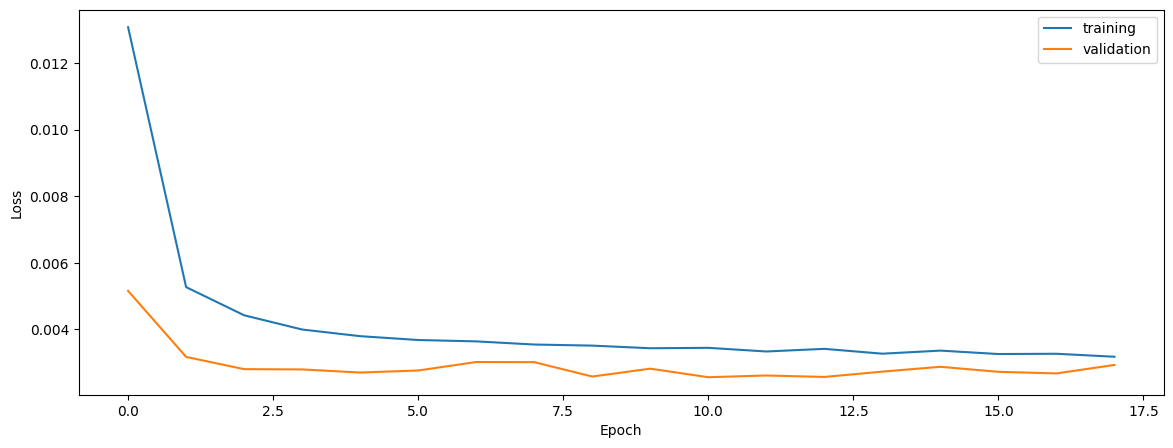

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.8709686392231593
0.9106988085516512
0.8486480553933227


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized
0.8709686392231593
0.9106988085516512
0.8486480553933227


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native
0.8820702963873173
0.9172712141068305
0.861995021930192


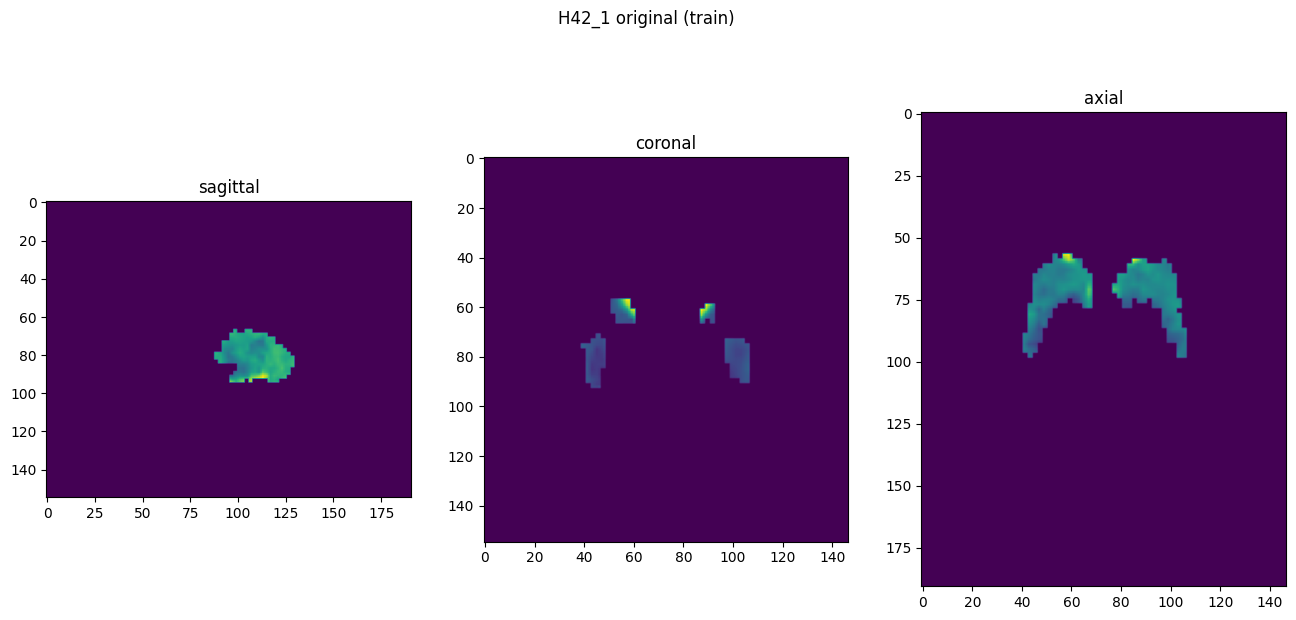

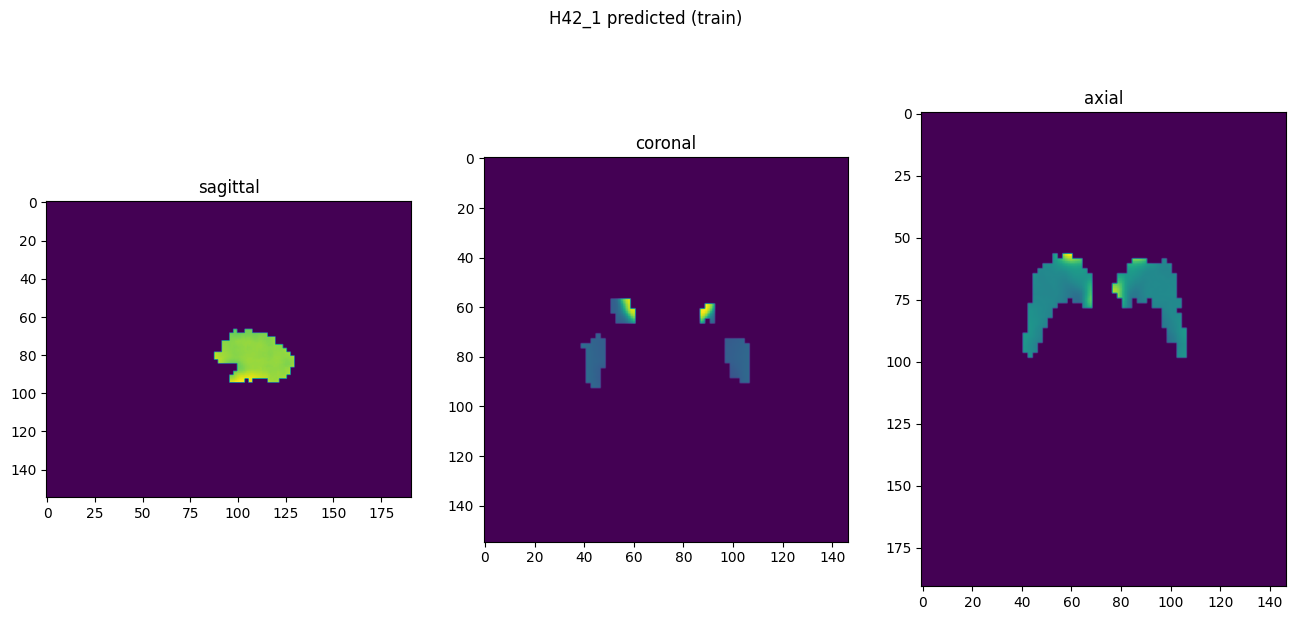

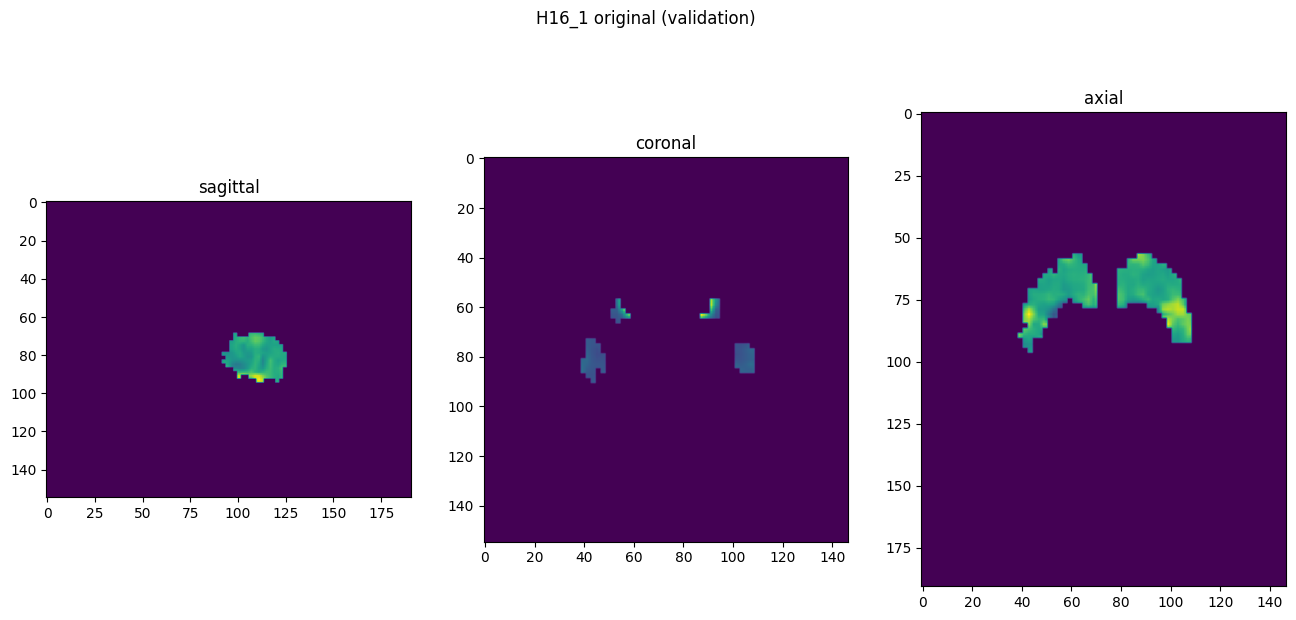

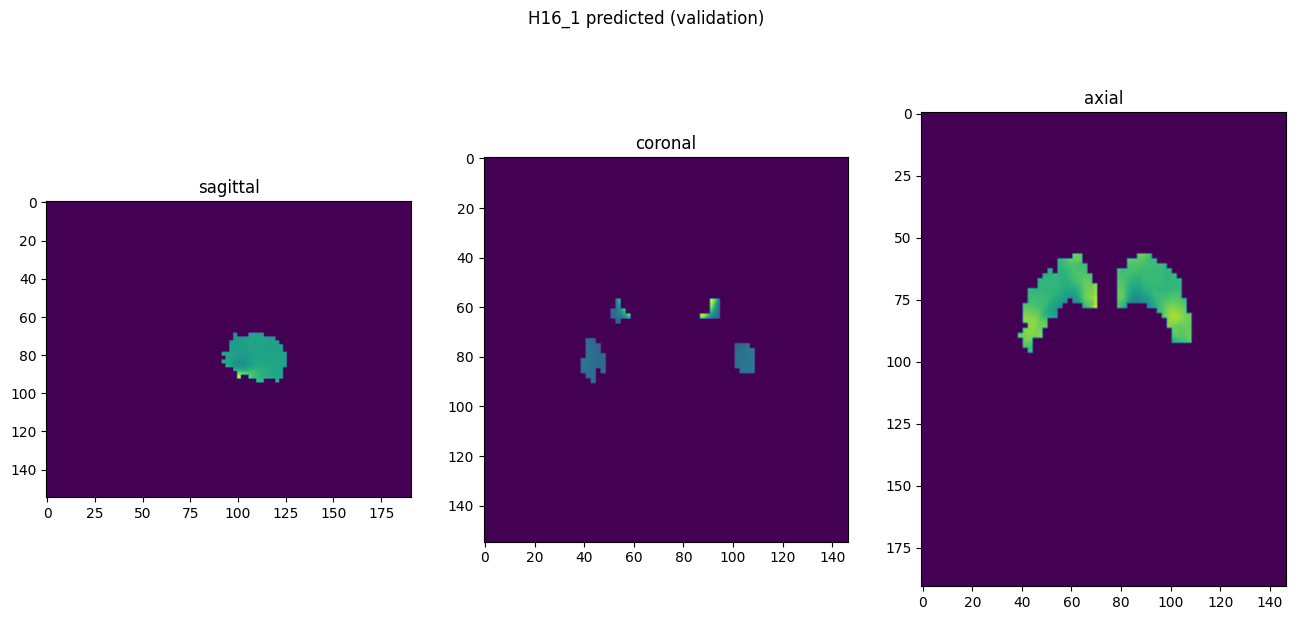

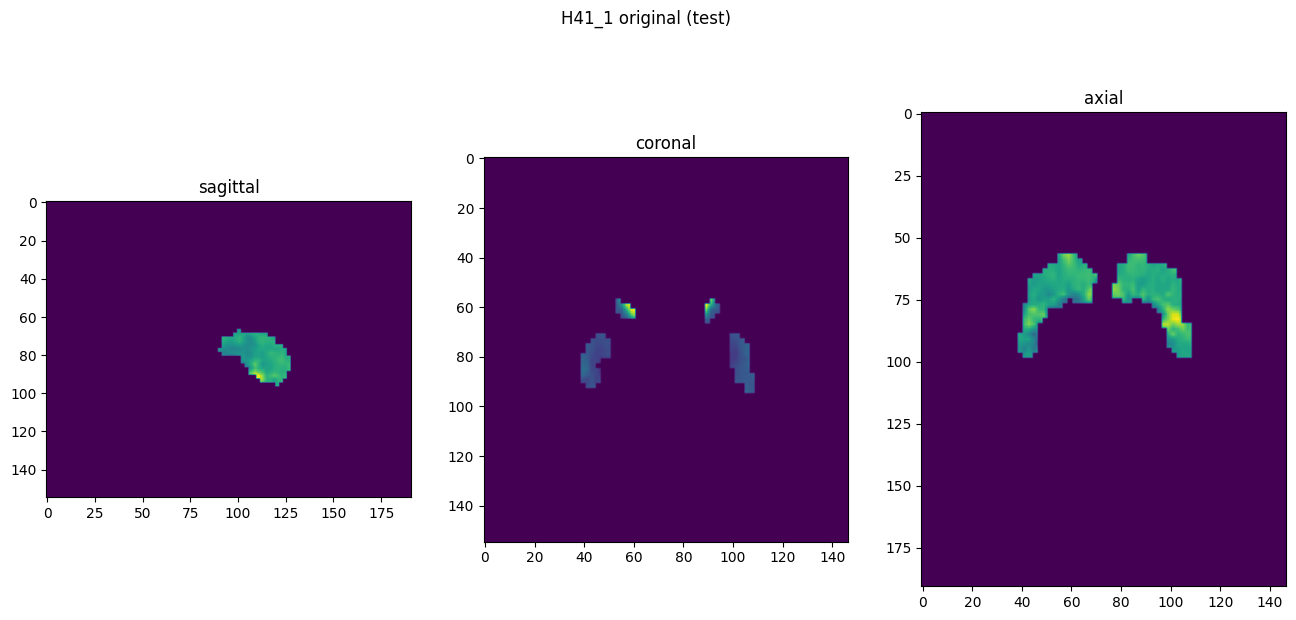

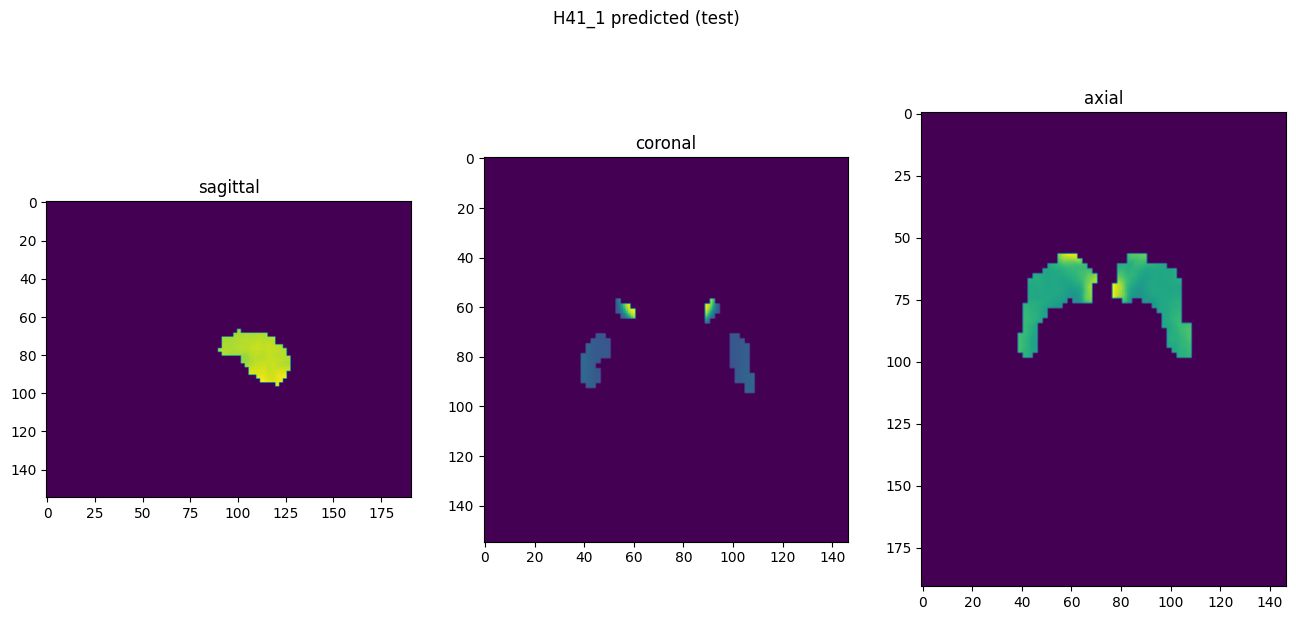

In [10]:
showResults(model, gen, threshold=None, background=False)